In [1]:
from datasets import load_from_disk
from spdata.utils import get_save_dir
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

/home/k_ishikawa/miniconda3/envs/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [59]:
ds = load_from_disk(str(get_save_dir("Spiral-AI/wikipedia", subset="hojichar")))
ds = ds["train"].filter(lambda x: len(x["text"]) > 8000)

Filter: 100%|██████████| 1273233/1273233 [00:10<00:00, 127171.73 examples/s]


: 

In [3]:
def calc_loss(model, tokenizer, ds):
    lengths = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4095]
    total_loss = {l: 0 for l in lengths}
    for t in tqdm(ds[:100]["text"]):
        inputs = tokenizer(
            t,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=4096,
        )
        input_ids = inputs["input_ids"].to(model.device)
        # inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits
            logits = logits

            for l in lengths:
                loss = F.cross_entropy(
                    logits[0, :l],
                    input_ids[0, 1 : l + 1],
                )
                total_loss[l] += loss.item()

    for l in lengths:
        print(f"Loss at {l}: {total_loss[l] / 100}")

    return total_loss

In [58]:
from retnet.modeling_retnet import RetNetForCausalLM

# Load model
tokenizer = AutoTokenizer.from_pretrained("cyberagent/calm2-7b-chat")
tokenizer.pad_token = tokenizer.eos_token

model = RetNetForCausalLM.from_pretrained(
    "/nas/y_sasaki/results/RetNet/retnet3b_ctxLen2048_datav1/checkpoint-20200",
    device_map="auto",
)
model.eval()

Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


RetNetForCausalLM(
  (model): RetNetModel(
    (dropout_module): Dropout(p=0.0, inplace=False)
    (embed_tokens): Embedding(65024, 2560, padding_idx=0)
    (layernorm_embedding): RMSNorm()
    (layers): ModuleList(
      (0-31): 32 x RetNetDecoderLayer(
        (dropout_module): Dropout(p=0.0, inplace=False)
        (retention): MultiScaleRetention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=False)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=False)
          (v_proj): Linear(in_features=2560, out_features=4280, bias=False)
          (g_proj): Linear(in_features=2560, out_features=4280, bias=False)
          (out_proj): Linear(in_features=4280, out_features=2560, bias=False)
          (group_norm): RMSNorm()
        )
        (retention_layer_norm): RMSNorm()
        (ffn): GLU(
          (activation_dropout_module): Dropout(p=0.0, inplace=False)
          (dropout_module): Dropout(p=0.0, inplace=False)
          (fc1): Linear(in_featu

In [ ]:
text_dataset = []
for t in tqdm(ds["train"]["text"]):
    text_dataset.append()

In [5]:
results_retnet = calc_loss(model, tokenizer, ds)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [06:20<00:00,  3.81s/it]

Loss at 2: 7.450924191474915
Loss at 4: 5.963250620365143
Loss at 8: 4.530715436935425
Loss at 16: 3.654140603542328
Loss at 32: 3.0588982915878296
Loss at 64: 2.8709265792369845
Loss at 128: 2.869863194227219
Loss at 256: 2.87728711605072
Loss at 512: 2.953042159080505
Loss at 1024: 2.9605975413322447
Loss at 2048: 2.982403373718262
Loss at 4095: 4.247141609191894


In [6]:
del model
model = AutoModelForCausalLM.from_pretrained(
    "cyberagent/open-calm-3b", trust_remote_code=True, device_map="auto"
)
model.eval()
tokenizer = AutoTokenizer.from_pretrained("cyberagent/open-calm-3b")

In [7]:
results_calm = calc_loss(model, tokenizer, ds)

100%|██████████| 100/100 [03:25<00:00,  2.06s/it]

Loss at 2: 5.970822483301163
Loss at 4: 4.368245644569397
Loss at 8: 3.3553948163986207
Loss at 16: 2.7801341927051544
Loss at 32: 2.6156303137540817
Loss at 64: 2.547611443400383
Loss at 128: 2.657185206413269
Loss at 256: 2.7351038587093353
Loss at 512: 2.821751655340195
Loss at 1024: 2.839653739929199
Loss at 2048: 3.4603604078292847
Loss at 4095: 32.2485899066925


In [57]:
# del model
model = AutoModelForCausalLM.from_pretrained(
    "abeja/gpt-neox-japanese-2.7b", device_map="auto"
)
model.eval()
tokenizer = AutoTokenizer.from_pretrained("abeja/gpt-neox-japanese-2.7b")
tokenizer.pad_token = tokenizer.eos_token

KeyboardInterrupt: 

In [ ]:
results_phi = calc_loss(model, tokenizer, ds)

100%|██████████| 100/100 [03:34<00:00,  2.14s/it]

Loss at 2: 4.5732068037986755
Loss at 4: 4.122578799128532
Loss at 8: 4.142653670310974
Loss at 16: 3.8508005857467653
Loss at 32: 3.199223839044571
Loss at 64: 2.6938950455188753
Loss at 128: 2.4748454868793486
Loss at 256: 2.316778316497803
Loss at 512: 2.203808982372284
Loss at 1024: 2.1537558913230894
Loss at 2048: 2.075669893026352
Loss at 4095: 3.1545947265625


In [ ]:
results_phi_ = {k: v / 100 for k, v in results_phi.items()}

In [ ]:
results_phi_

In [ ]:
abeja =

In [53]:
phi2 = {
    2: 4.5732068037986755,
    4: 4.122578799128532,
    8: 4.142653670310974,
    16: 3.8508005857467653,
    32: 3.199223839044571,
    64: 2.6938950455188753,
    128: 2.4748454868793486,
    256: 2.316778316497803,
    512: 2.203808982372284,
    1024: 2.1537558913230894,
    2048: 2.075669893026352,
    4095: 3.1545947265625,
}

In [43]:
retnet = {
    2: 7.450924191474915,
    4: 5.963250620365143,
    8: 4.530715436935425,
    16: 3.654140603542328,
    32: 3.0588982915878296,
    64: 2.8709265792369845,
    128: 2.869863194227219,
    256: 2.87728711605072,
    512: 2.953042159080505,
    1024: 2.9605975413322447,
    2048: 2.982403373718262,
    4095: 4.247141609191894,
}  # retnet

In [44]:
calm = {
    2: 5.970822483301163,
    4: 4.368245644569397,
    8: 3.3553948163986207,
    16: 2.7801341927051544,
    32: 2.6156303137540817,
    64: 2.547611443400383,
    128: 2.657185206413269,
    256: 2.7351038587093353,
    512: 2.821751655340195,
    1024: 2.839653739929199,
    2048: 3.4603604078292847,
    4095: 32.2485899066925,
}  # calm

In [45]:
stab = {
    2: 2.8349369579553603,
    4: 2.589925986528397,
    8: 2.3791239577531815,
    16: 1.7904255044460298,
    32: 1.3889614015817642,
    64: 1.230473981499672,
    128: 1.1948255816102027,
    256: 1.2017519199848175,
    512: 1.1976291835308075,
    1024: 1.2195418030023575,
    2048: 1.2228431409597398,
    4095: 1.221167697906494,
}  # stability

In [10]:
4.298597238063812  # RetNet
32.2485899066925  # OpenCALM

32.2485899066925

In [11]:
results_retnet_ = {k: v / 100 for k, v in results_retnet.items()}
results_calm_ = {k: v / 100 for k, v in results_calm.items()}
results_phi_ = {k: v / 100 for k, v in results_phi.items()}

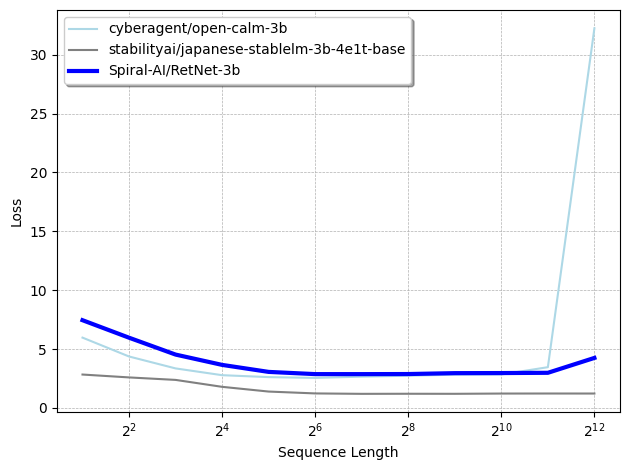

In [41]:
# compare the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(
    results_calm.keys(),
    results_calm_.values(),
    label="cyberagent/open-calm-3b",
    color="lightblue",
)
ax.plot(
    results_phi.keys(),
    results_phi_.values(),
    label="stabilityai/japanese-stablelm-3b-4e1t-base",
    color="grey",
)
ax.plot(
    results_retnet.keys(),
    results_retnet_.values(),
    label="Spiral-AI/RetNet-3b",
    linewidth=3,
    color="blue",
)
ax.set_xlabel("Sequence Length")
ax.set_ylabel("Loss")
ax.set_xscale("log", base=2)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
# ax.legend()
ax.legend(frameon=True, shadow=True)
plt.tight_layout()
plt.show()

In [42]:
fig.savefig("loss_comparison_with_stab.png", dpi=300)

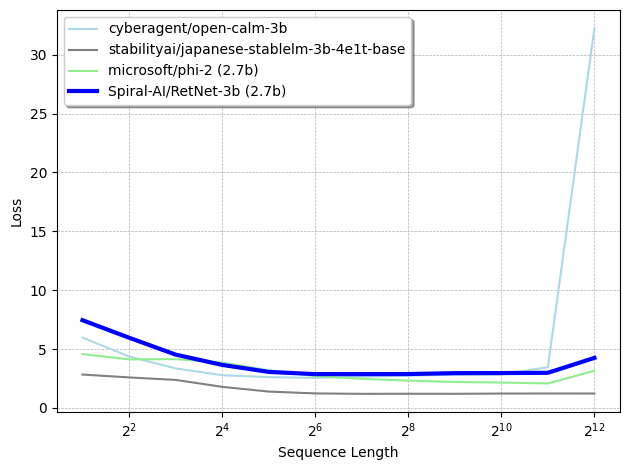

In [ ]:
# compare the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(
    calm.keys(),
    calm.values(),
    label="cyberagent/open-calm-3b",
    color="lightblue",
)

ax.plot(
    stab.keys(),
    stab.values(),
    label="stabilityai/japanese-stablelm-3b-4e1t-base",
    color="grey",
)
ax.plot(
    phi2.keys(),
    phi2.values(),
    label="microsoft/phi-2",
    color="lightgreen",
)
ax.plot(
    abeja.keys(),
    abeja.values(),
    label="abeja/gpt-neox-japanese-2.7b",
    color="lightcoral",
)
ax.plot(
    retnet.keys(),
    retnet.values(),
    label="Spiral-AI/RetNet-3b",
    linewidth=3,
    color="blue",
)
ax.set_xlabel("Sequence Length")
ax.set_ylabel("Loss")
ax.set_xscale("log", base=2)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
# ax.legend()
ax.legend(frameon=True, shadow=True)
plt.tight_layout()
plt.show()

In [56]:
fig.savefig("loss_comparison.png", dpi=300)